In [2]:
import pandas as pd

In [3]:
from sklearn.feature_extraction import DictVectorizer

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
top_dir = '/home/ubuntu/mlops-zoomcamp/data'
files = ['fhv_tripdata_2021-01.parquet', 'fhv_tripdata_2021-02.parquet']

In [6]:
data_list = []
for f in files:
    df = pd.read_parquet(top_dir+'/'+f)
    data_list.append(df)
    print(df.shape)

data = pd.DataFrame() 
data = pd.concat(data_list, ignore_index=True)
data.head()

(1154112, 7)
(1037692, 7)


,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


## Question 1
#### How many rows are there for January 2021

In [7]:
data[data['pickup_datetime'].dt.month == 1].shape

(1154112, 7)

## Question 2 
#### What's the average trip duration in January

In [8]:
data['duration'] = data['dropOff_datetime'] - data['pickup_datetime']
data['duration_min'] = (data.duration.dt.seconds)/60
jan = data[(data['pickup_datetime'].dt.month == 1)].copy() # & (data['PUlocationID'].notna()) & (data['DOlocationID'].notna())].copy()
jan.duration_min.mean()


18.610744306736674

## Data Preparation


<AxesSubplot:ylabel='Frequency'>

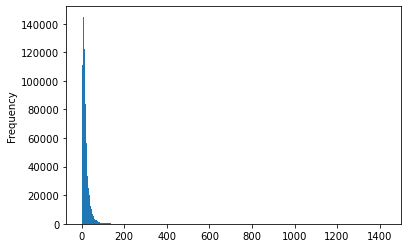

In [9]:
data.duration_min.plot.hist(bins=1000)

In [10]:
data_min_filter = data[(data['duration_min'] >= 1) & (data['duration_min'] <= 60) ].copy()

In [11]:
data_min_filter[data_min_filter['pickup_datetime'].dt.month == 1].duration_min.mean()

16.247430951067546

## Question 3
The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

In [12]:
data_min_filter['PUlocationID'].fillna(-1, inplace=True)
data_min_filter['DOlocationID'].fillna(-1, inplace=True)


In [13]:
data_min_filter[(data_min_filter['PUlocationID'] == -1) & (data_min_filter['pickup_datetime'].dt.month == 1)].shape[0] / data_min_filter[
    (data_min_filter['pickup_datetime'].dt.month == 1)
].shape[0]

0.835275482428754

## Q4. One-hot encoding


In [14]:
X_train_dict = data_min_filter[(data_min_filter['pickup_datetime'].dt.month == 1)][['PUlocationID', 'DOlocationID']].to_dict('records')
X_test_dict = data_min_filter[(data_min_filter['pickup_datetime'].dt.month != 1)][['PUlocationID', 'DOlocationID']].to_dict('records')

dic_vec = DictVectorizer()

X_train = dic_vec.fit_transform(X_train_dict)
X_test = dic_vec.transform(X_test_dict)

In [15]:
Y_train = data_min_filter[(data_min_filter['pickup_datetime'].dt.month == 1)]['duration_min']
Y_test = data_min_filter[(data_min_filter['pickup_datetime'].dt.month != 1)]['duration_min']

In [21]:
X_train

<1109853x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2219706 stored elements in Compressed Sparse Row format>

In [16]:
model = LinearRegression()

## Q5. Training a model
#### RMSE on train

In [17]:
model.fit(X_train, Y_train)

LinearRegression()

In [19]:
Y_pred = model.predict(X_train)
mean_squared_error(Y_train, Y_pred, squared=False)

11.415550966867276

# Q6. Evaluating the model
#### RMSE on Validation

In [20]:
Y_pred_val = model.predict(X_test)
mean_squared_error(Y_test, Y_pred_val, squared=False)

11.858528336684484